# **Rossman Sales Prediction**
### *Diego Armando Salinas Lugo ds24353*



#### Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

#### Reliable sales forecasts enable store managers to create effective staff schedules that increase productivity and motivation. 

#### In this notebook, I implement the steps to predict 6 weeks of daily sales for 1,115 stores located across Germany. 



In [1]:
!pip install matplotlib
!pip install tensorflow

### First of all, preprocessing the data is truly important in order to proceed with the modelling for the predictions
#### The files given are : train (contains historical data), test (data to model and predict) and store (to provide additional information about each store)
#### Below, I paste the content of my file for preprocessing the data with comments to describe how it works.



#### Basically what it does is:
##### - Loads the three provided CSV files into Pandas DataFrames for processing. 
##### - Handles Missing Values
##### - Converts Date columns to DateTime Format
##### - Extracts Date Features
##### - Combines the store-specific information from store.csv into the train and test datasets using the Store column as a key.
##### - Calculates Competition Open Duration
##### - Calculates Promo2 Active Duration
##### - Drops columns that are redundant or irrelevant for modeling.
##### - Saves the preprocessed data

### After preprocessing the data, I load the file of train_data to visualize it and see correlations


C:\Users\Salin\AppData\Local\Temp\ipykernel_14436\1961538526.py:5: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv("train_preprocessed.csv")


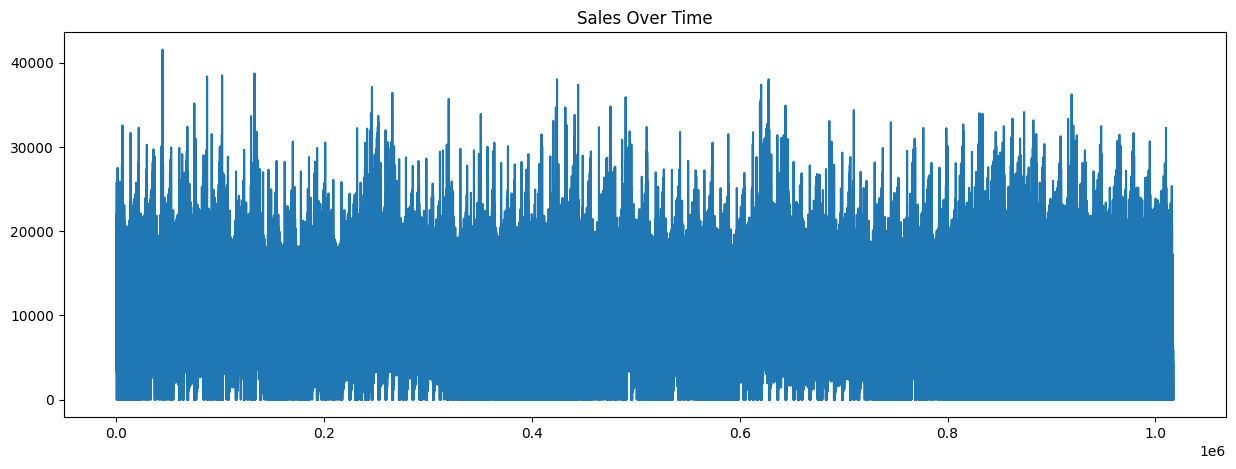

Sales                  1.000000
Open                   0.678472
Promo                  0.452345
Promo2Open             0.091083
SchoolHoliday          0.085124
WeekOfYear             0.052946
Month                  0.048768
DayOfYear              0.047503
Year                   0.023519
Store                  0.005126
CompetitionOpen       -0.002709
Day                   -0.011612
CompetitionDistance   -0.018869
Promo2                -0.091040
DayOfWeek             -0.462125
Name: Sales, dtype: float64


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Loading preprocessed training data
train_data = pd.read_csv("train_preprocessed.csv")

# Visualizing sales over time
train_data['Sales'].plot(kind='line', figsize=(15, 5), title='Sales Over Time')
plt.show()

# Selecting only numeric columns for correlation, if not, i would have error since i have strings in some columns
numeric_data = train_data.select_dtypes(include=['number'])

# To calculate and display correlation matrix, in order to see features relevance
correlations = numeric_data.corr()
print(correlations['Sales'].sort_values(ascending=False))

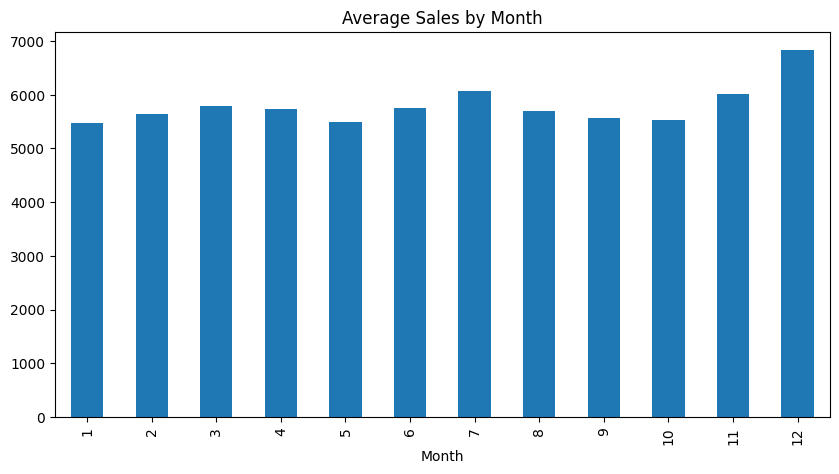

In [3]:
# Grouping sales by Month
monthly_sales = train_data.groupby('Month')['Sales'].mean()
monthly_sales.plot(kind='bar', title='Average Sales by Month', figsize=(10, 5))
plt.show()

### Now, with the processed data. I am choosing to work with Feedforward Neural Network (FNN), also known as a Multilayer Perceptron (MLP) for modelling and doing the predictions since after researching I found out that: 

#### - *This model is designed specifically for structured/tabular data.*
#### - *Neural networks can model complex, non-linear relationships between features and the target variable.*
#### - *It works well with large datasets and can handle many features.*
#### - *Modern techniques can be applied as : adding dropout, early stopping, and scaling ensures better performance and generalization.*

### Which suits well with Rossmann Sales proyect, since: 

#### - *It has structured/tabular data like the features.*
#### - *The dataset is large enough for a neural network to learn meaningful patterns.*
#### - *The problem involves complex relationships between features and sales, which FNNs can model effectively.*

#### This model is a Deep Learning model because it has multiple layers, is built using a Deep Learning framework (TensorFlow/Keras), and is designed to learn complex patterns in the data.

In [4]:
#Importing the necessary libraries for the modelling

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping

In [5]:
# Defining features and target

features = ['Open', 'Promo', 'Promo2Open', 'DayOfWeek', 'CompetitionDistance', 'CompetitionOpen', 'Month', 'DayOfYear']
X = train_data[features] # Selecting the specified feature columns from the dataset
y = train_data['Sales'] # Setting the variable to be predicted by the model

# Splitting data into training and validation sets
# X_train = Features for training
# X_val = Featues for validation
# y_train = Target variable for training
# y_val = Target variable for validation
# test_size = 0.3 Keeps 30% of the data for validation
# random state = 42 Ensures consistent results by using a fixed random seed.
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)


In [6]:
# Scaling features

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [7]:
# Scaling target variable

target_scaler = MinMaxScaler()
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_val_scaled = target_scaler.transform(y_val.values.reshape(-1, 1))

In [8]:
# Defining the neural network

nn_model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),  # Input layer
    Dense(128, activation='relu'),           # Hidden layer 1 with 128 nodes
    Dropout(0.3),                            # Dropout layer to prevent overfitting
    Dense(64, activation='relu'),            # Hidden layer 2 with 64 nodes
    Dropout(0.3),                            # Dropout layer
    Dense(32, activation='relu'),            # Hidden layer 3 with 32 nodes
    Dense(1)                                 # Output layer (1 node for regression)
])

# The Dropout is effective for overfitting, encourages the network to learn robust, distributed representations.

In [9]:
# Compiling the model

nn_model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Using a small learning rate
    loss='mse',                            # Mean Squared Error as loss
    metrics=['mse']                        # Monitor Mean Squared Error
)


In [10]:
# Early stopping callback

early_stopping = EarlyStopping(
    monitor='val_loss',       # To monitor validation loss
    patience=10,              # Stopping if no improvement for 10 epochs
    restore_best_weights=True # Restoring model weights from the best epoch
)


In [11]:
# Training the model

history = nn_model.fit(
    X_train_scaled, y_train_scaled,  # Scaled inputs and target
    validation_data=(X_val_scaled, y_val_scaled),  # Validation data
    epochs=100,       # Trainning for a maximum of 100 epochs
    batch_size=32,    # Using a batch size of 32, the numbers of samples processed at a time before updating thw models weights
    verbose=1,        # To display progress
    callbacks=[early_stopping]  # Includes the early stopping
)


Epoch 1/100
25431/25431 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step - loss: 0.0086 - mse: 0.0086 - val_loss: 0.0045 - val_mse: 0.0045
Epoch 2/100
25431/25431 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - loss: 0.0044 - mse: 0.0044 - val_loss: 0.0044 - val_mse: 0.0044
Epoch 3/100
25431/25431 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - loss: 0.0043 - mse: 0.0043 - val_loss: 0.0043 - val_mse: 0.0043
Epoch 4/100
25431/25431 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - loss: 0.0042 - mse: 0.0042 - val_loss: 0.0043 - val_mse: 0.0043
Epoch 5/100
25431/25431 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - loss: 0.0042 - mse: 0.0042 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 6/100
25431/25431 ━━━━━━━━━━━━━━━━━━━━ 39s 2ms/step - loss: 0.0042 - mse: 0.0042 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 7/100
25431/25431 ━━━━━━━━━━━━━━━━━━━━ 39s 2ms/step - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 8/100
25431/25431 ━━━━━━━━━━━━━━━━━━━━ 39s 2ms/step - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 9/

In [12]:
# Evaluating the model

val_loss, val_mse = nn_model.evaluate(X_val_scaled, y_val_scaled, verbose=0)
val_rmse_scaled = val_mse ** 0.5 
print(f"Validation RMSE (scaled): {val_rmse_scaled:.2f}")

# Converting scaled MSE back to RMSE in the original scale
# Scaler's `data_max_` and `data_min_` to calculate the range
data_range = target_scaler.data_max_[0] - target_scaler.data_min_[0]  # Extract scalar values
val_rmse = (val_mse ** 0.5) * data_range  # Scale back RMSE
print(f"Validation RMSE (original scale): {val_rmse:.2f}")


Validation RMSE (scaled): 0.06
Validation RMSE (original scale): 2388.28


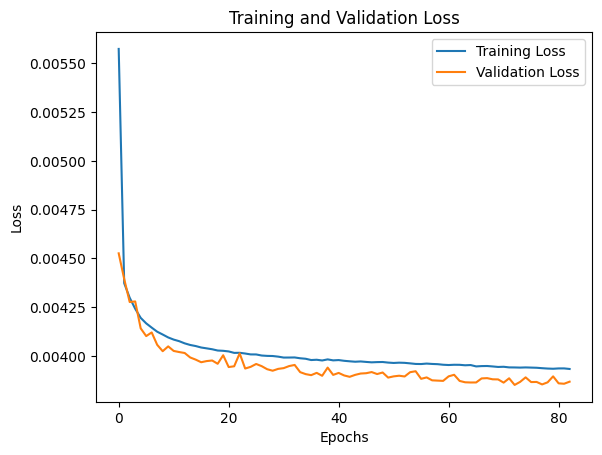

In [13]:
# Plotting the training and validation loss

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [14]:
# Scaling the test data

test_preprocessed = pd.read_csv("test_preprocessed.csv")
X_test_scaled = scaler.transform(test_preprocessed[features])

# Predicting sales on test data
test_predictions_scaled = nn_model.predict(X_test_scaled)

# Scaling predictions back to original range
test_predictions = target_scaler.inverse_transform(test_predictions_scaled)

# Preparing the output file
submission = pd.DataFrame({
    'Id': test_preprocessed['Id'],  
    'Sales': test_predictions.flatten()
})
submission.to_csv("Sales_Prediction.csv", index=False) # The final output
print("Sales Prediction file has been created")


  65/1284 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step 

C:\Users\Salin\AppData\Local\Temp\ipykernel_14436\29258116.py:3: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  test_preprocessed = pd.read_csv("test_preprocessed.csv")


1284/1284 ━━━━━━━━━━━━━━━━━━━━ 1s 640us/step
Sales Prediction file has been created
